In [ ]:
!pip install -r requirements.txt

In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
from easyocr import easyocr
import re


In [ ]:
def preprocess(image):
    # Загрузка изображения в черно-белом формате
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)
    canny = cv2.Canny(blurred, 100, 200)

    # Поиск контуров
    contours, _ = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_TC89_L1)
    contours = sorted(contours, key=cv2.contourArea)
    # Фильтрация контуров по пропорциям
    plate_candidate = None
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = w / float(h)
        if 3.3 < aspect_ratio < 5.1 and w > 80 and h > 15:
            roi = canny[y:y + h, x:x + w]  # Вырезаем область из бинарного изображения
            # Находим контуры внутри ROI
            inner_contours, _ = cv2.findContours(roi, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
            letter_count = 0
            for lc in inner_contours:
                _, _, lc_w, lc_h = cv2.boundingRect(lc)
                if lc_w>10 and lc_h>25:
                    letter_count+=1
            if letter_count > 5:
                plate_candidate = (x, y, w, h)
                break

    # Возвращаем найденные таблички или одну (например, первую)
    result_img = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
    if plate_candidate is not None:
        x, y, w, h = plate_candidate
        cv2.rectangle(result_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return canny, result_img, plate_candidate

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from easyocr import easyocr
import re



# убираем шум
def prepare_plate_img(plate_img):
    img_gray = cv2.cvtColor(plate_img.copy(), cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(img_gray, (5, 5), 1)
    threshold, binary_img = cv2.threshold(blurred, 80, 255, cv2.THRESH_BINARY)

    # Создаем ядро (структурный элемент) для морфологических операций — квадрат 2x2 пикселей
    kernel = np.ones((2, 2), np.uint8)
    # 2) Дилатация — расширяет белые области, увеличивает объекты, заполняет пробелы
    dilation = cv2.dilate(binary_img, kernel, iterations=1, borderType=cv2.BORDER_CONSTANT)
    return dilation

def clean_text(text):
    # Keep only letters and digits
    cleaned = re.sub(r'[^A-Za-zА-Яа-яЁё0-9]', '', text)

    # Safety check
    if len(cleaned) <= 5:
        return cleaned  # Too short to split

    # Split after index 5
    return cleaned[:6] + ' ' + cleaned[6:]

def get_text(plate_img):
    reader = easyocr.Reader(['ru'])
    results = reader.readtext(plate_img)
    text_string = ' '.join([res[1] for res in results])
    text_string = clean_text(text_string)
    return text_string


In [ ]:
import abc
import random
class ImageTransformer(abc.ABC):
    @abc.abstractmethod
    def random_transform(self, img: np.ndarray) -> np.ndarray:
        pass


class ColorTransformer(ImageTransformer):
    def random_transform(self, img: np.ndarray) -> np.ndarray:
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float32)

        # Random hue (-10 to +10), saturation (0.8–1.2), brightness (0.8–1.2)
        hue_shift = random.uniform(-1, 1)
        sat_mult = random.uniform(0.9, 1.1)
        val_mult = random.uniform(0.9, 1.1)

        hsv[..., 0] = (hsv[..., 0] + hue_shift) % 180
        hsv[..., 1] *= sat_mult
        hsv[..., 2] *= val_mult

        # Clip and convert back
        hsv = np.clip(hsv, 0, 255).astype(np.uint8)
        return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

class GeometricTransformer(ImageTransformer):
    def random_transform(self, img: np.ndarray) -> np.ndarray:
        h, w = img.shape[:2]

        transform_type = random.choice([
           "crop", "zoom", "shift"
        ])

        if transform_type == "crop":
            start_x = random.randint(0, w // 10)
            start_y = random.randint(0, h // 10)
            end_x = w - random.randint(0, w // 10)
            end_y = h - random.randint(0, h // 10)
            cropped = img[start_y:end_y, start_x:end_x]
            return cv2.resize(cropped, (w, h))

        elif transform_type == "zoom":
            scale = random.uniform(0.8, 1.2)
            resized = cv2.resize(img, None, fx=scale, fy=scale)
            if scale < 1:
                pad_w = (w - resized.shape[1]) // 2
                pad_h = (h - resized.shape[0]) // 2
                return cv2.copyMakeBorder(resized, pad_h, pad_h, pad_w, pad_w,
                                          borderType=cv2.BORDER_REFLECT)
            else:
                return resized[:h, :w]

        elif transform_type == "shift":
            dx = random.randint(-w // 2, w // 2)
            dy = random.randint(-h // 2, h // 2)
            matrix = np.float32([[1, 0, dx], [0, 1, dy]])
            return cv2.warpAffine(img, matrix, (w, h), borderMode=cv2.BORDER_REFLECT)


        return img

class NoiseTransformer(ImageTransformer):
    def random_transform(self, img: np.ndarray) -> np.ndarray:
        noise_type = random.choice(["gaussian", "poisson", "salt", "pepper"])
        output = img.copy()

        if noise_type == "gaussian":
            mean = 0
            sigma = 10
            gauss = np.random.normal(mean, sigma, img.shape).astype(np.int16)
            output = np.clip(img.astype(np.int16) + gauss, 0, 255).astype(np.uint8)

        elif noise_type == "poisson":
            noisy = np.random.poisson(img.astype(np.float32))
            output = np.clip(noisy, 0, 255).astype(np.uint8)

        elif noise_type == "salt":
            amount = 0.01
            num_salt = int(amount * img.size)
            coords = [np.random.randint(0, i - 1, num_salt) for i in img.shape[:2]]
            output[coords[0], coords[1]] = 255

        elif noise_type == "pepper":
            amount = 0.01
            num_pepper = int(amount * img.size)
            coords = [np.random.randint(0, i - 1, num_pepper) for i in img.shape[:2]]
            output[coords[0], coords[1]] = 0

        return output


colorTransformer = ColorTransformer()
geometricTransformer = GeometricTransformer()
noiseTransformer = NoiseTransformer()
default_transformations = [colorTransformer, noiseTransformer, geometricTransformer]

def apply_augmentation(img: np.ndarray, transformations=default_transformations) -> np.ndarray:
    transformed_img = img.copy()
    for transform in transformations:
        transformed_img = transform.random_transform(transformed_img)
    return transformed_img

In [ ]:
def apply_pipeline(path):
    img = cv2.imread(path)
    img = apply_augmentation(img)
    canny, output_img, plate_coord = preprocess(img.copy())
    plate_img = None
    if plate_coord is not None:
        x, y, w, h = plate_coord
        plate_img = img[y:y + h, x:x + w]
        plate_img = prepare_plate_img(plate_img)
        plate_text = get_text(plate_img)
        print(plate_text)
        cv2.putText(output_img, plate_text, (x, y-10),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=1,
                    color=(0, 255, 0),
                    thickness=2,
                    lineType=cv2.LINE_AA)

    f, axes = plt.subplots(1, 3, figsize=(10, 5))
    axes[0].imshow(canny)
    axes[1].imshow(output_img)
    if plate_img is not None:
        axes[2].imshow(plate_img)
    plt.show()

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Н7Ь4кЕ 799


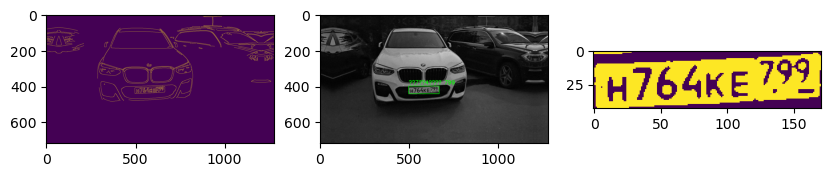

In [47]:
apply_pipeline('car1.jpg')

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


СООБкм 199


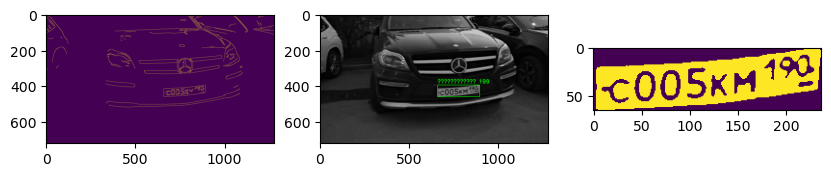

In [59]:
apply_pipeline('car2.jpg')

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


7154Е9 77


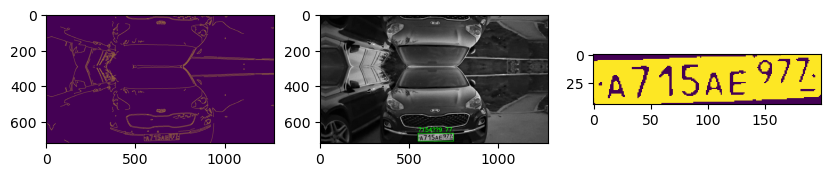

In [55]:
apply_pipeline('car3.jpg')